# [Computational Social Science] Project 4: Unsupervised Learning

**Enter your Name:** Juana Gabriela Montoya Murillo

*Semester:* Fall 2023

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer 

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical


import matplotlib.pyplot as plt
%matplotlib inline



2023-12-11 14:54:15.319264: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-11 14:54:15.451844: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-11 14:54:15.456949: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-11 14:54:15.456966: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

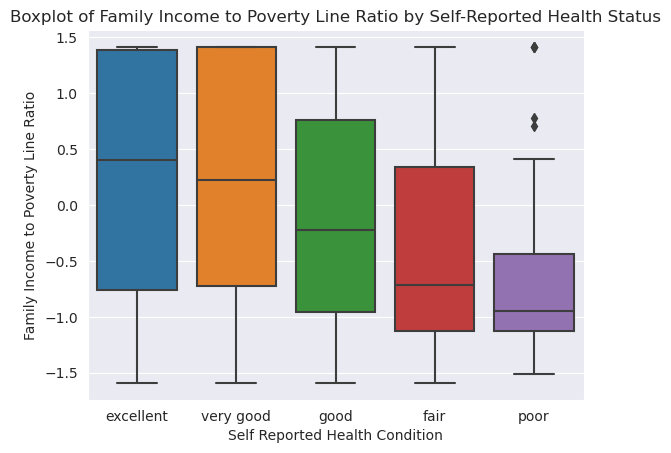

In [3]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = hsd010f =nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])

# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()


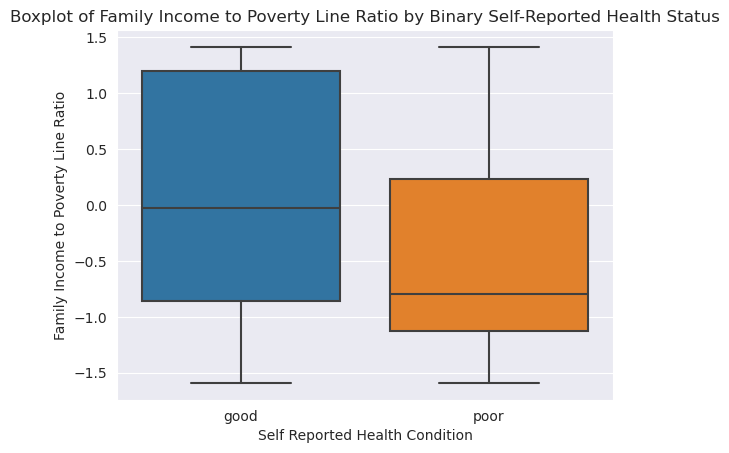

In [4]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

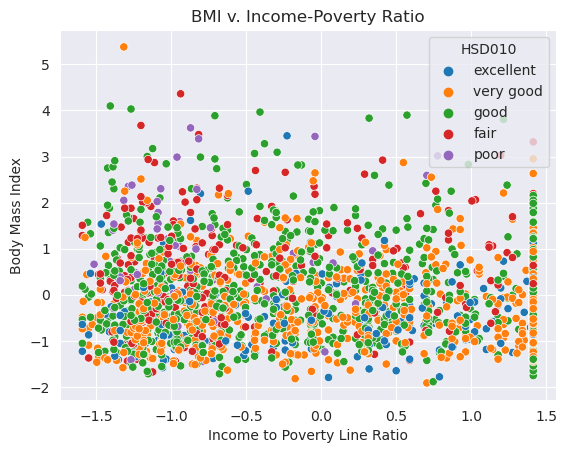

In [5]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

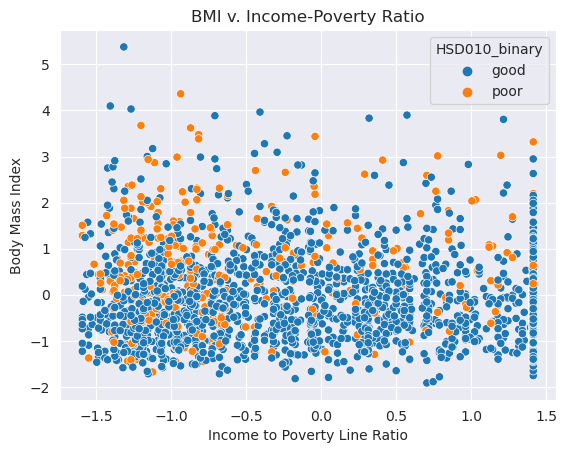

In [6]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = 'HSD010_binary', palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [7]:
nhanes_scaledf = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1) 

In [8]:
nhanes_scaledf.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ033,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,-0.680203,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,-0.680203,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,-0.680203,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,-0.680203,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-0.680203,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812


## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

In [9]:
## PCA
pca = PCA(n_components=30)
principalComponents_health = pca.fit_transform(nhanes_scaledf)


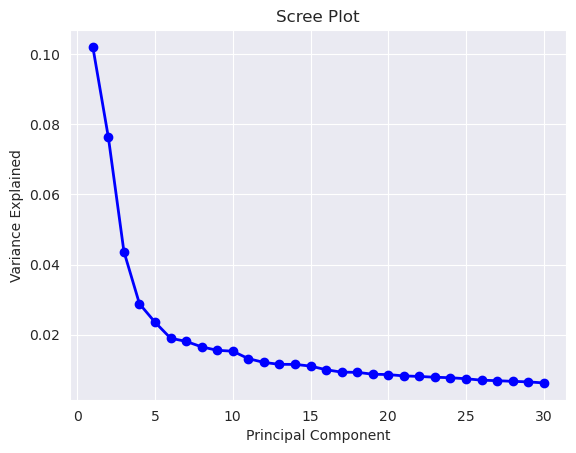

In [10]:
# create scree plot from PCA fit
# ----------
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

### Barplot of Components

**Choose the number of components and provide 1-2 sentences about your choice of the number of components.**



Based on the scree plot, two components were chosen because the plot shows a sharp decline in the variance explained after the first component and begins to level off after the second. This indicates that the first two components capture the most significant variance in the data, thus serving as a natural choice for dimensionality reduction while retaining the most important information from the dataset.

### How many components will you use to fit a supervised learning model?

In [11]:
## PCA
pcaf = PCA(n_components=2)
principalComponentsf_health = pcaf.fit(nhanes_scaledf)

In [12]:
## Number of components
explained_varf = principalComponentsf_health.explained_variance_ratio_
cum_explained_varf = np.cumsum(explained_varf)


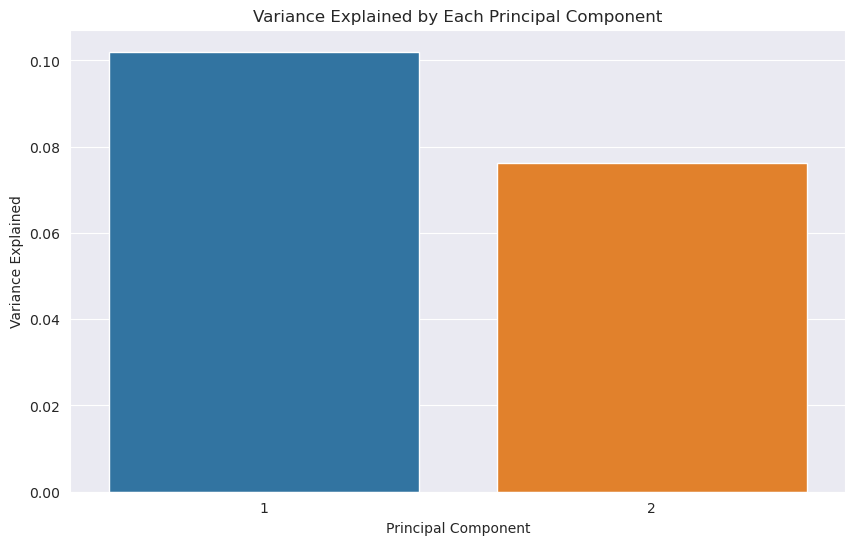

In [13]:
# Plot a barplot of the variation explained by each component
plt.figure(figsize=(10, 6))
sns.barplot(x=np.arange(1, len(explained_varf)+1), y=explained_varf)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Variance Explained by Each Principal Component')
plt.show()

In [14]:
principalComponentsft_health = pcaf.fit_transform(nhanes_scaledf)

In [15]:
pca_df = pd.DataFrame(data = principalComponentsft_health, 
                      columns = ['principal component 1', 
                                 'principal component 2'])

In [16]:
pca_df.head()

,principal component 1,principal component 2
0,9.527811,-0.816231
1,-5.838339,-3.692579
2,-0.719455,-2.573204
3,3.533628,-2.576977
4,-6.872095,-4.194236


### 2D Scatterplot of the first two components

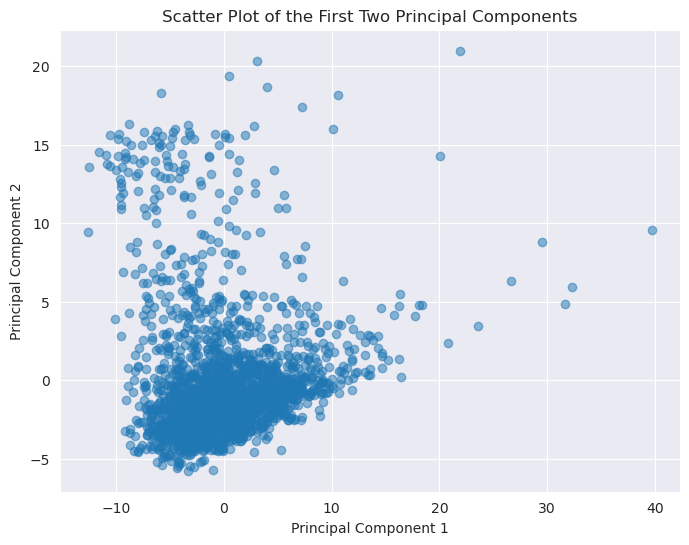

In [17]:
plt.figure(figsize=(8, 6))
plt.scatter(principalComponentsft_health[:, 0], principalComponentsft_health[:, 1], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot of the First Two Principal Components')
plt.show()

In [18]:
pcaf_df = pd.DataFrame(data = principalComponentsft_health, 
                      columns = ['principal component 1', 
                                 'principal component 2'])
pcaf_df['HSD010'] = hsd010
#Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
pcaf_df['HSD010_binary'] = pcaf_df['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 

# Recode the original hsd010 with the string labels
pcaf_df['HSD010'] = pcaf_df['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])



In [19]:
pcaf_df.head()

,principal component 1,principal component 2,HSD010,HSD010_binary
0,9.527811,-0.816231,excellent,good
1,-5.838339,-3.692579,excellent,good
2,-0.719455,-2.573204,very good,good
3,3.533628,-2.576977,very good,good
4,-6.872095,-4.194236,good,good


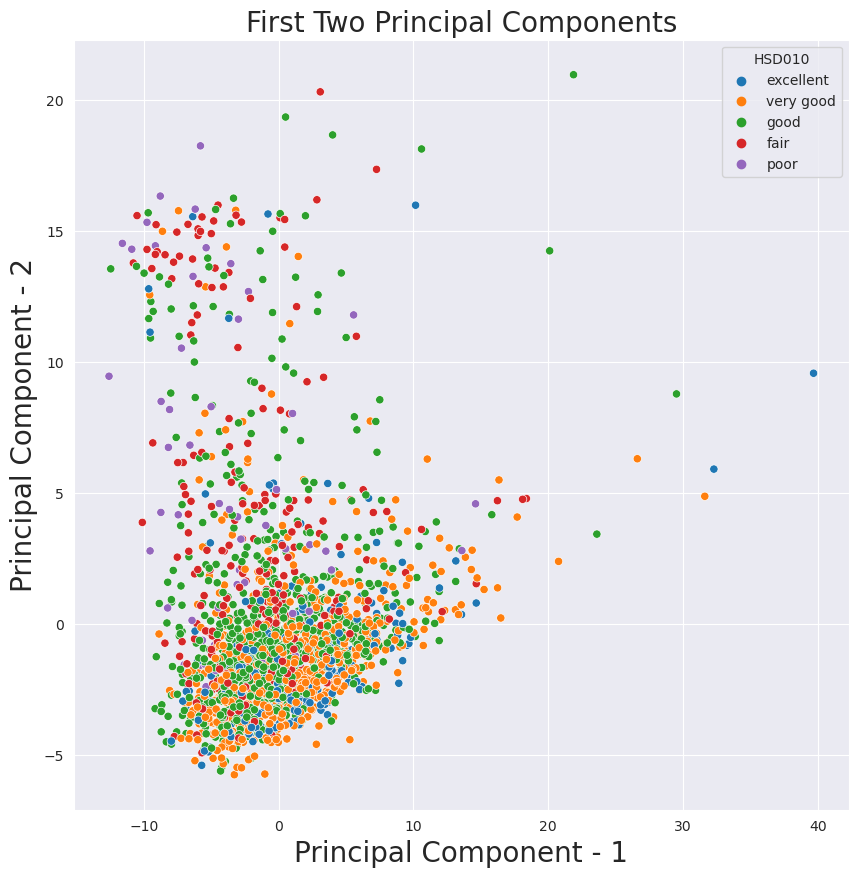

In [20]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x = "principal component 1", y = "principal component 2", hue = "HSD010", palette = "tab10", data = pcaf_df)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("First Two Principal Components",fontsize=20)
plt.show()

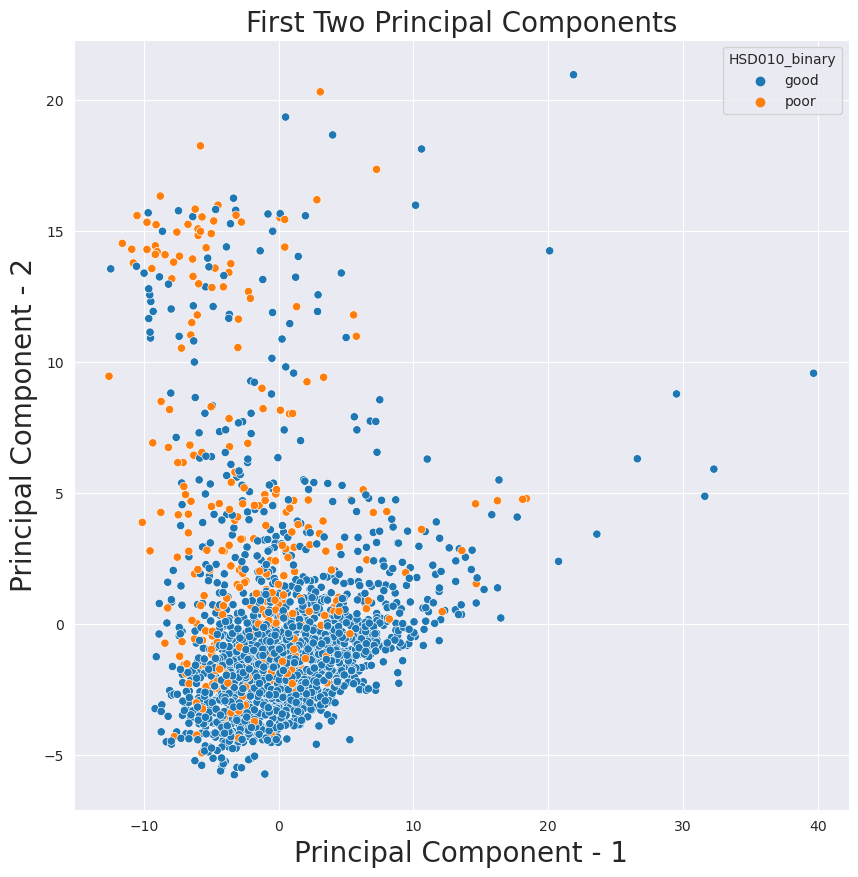

In [21]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x = "principal component 1", y = "principal component 2", hue = "HSD010_binary", palette = "tab10", data = pcaf_df)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("First Two Principal Components",fontsize=20)
plt.show()

**Analysis:** 

The first plot has a lot of dots close to the middle, showing that a lot of the health information is alike. Some dots are far from the middle, which means those are different from the rest.

The colored plots also show health, but with more detail. Even though dots with the same color are supposed to be near each other, they're quite scattered. So, our health data is related, but it's not straightforward or easy to separate into clear groups.

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

#### K-means

For this project, I would choose between KMeans and Ward clustering as they are both effective for data that clusters tightly in one area. KMeans excels with data that forms circular clusters of similar sizes, making it a straightforward choice for evenly distributed data. On the other hand, Ward's method is advantageous for data with clusters of varying sizes and non-circular shapes that remain in proximity to each other. Given the nature of our data, KMeans is the preferred algorithm for its simplicity and efficiency in handling well-defined, spherical clusters.

### Cluster nhanes

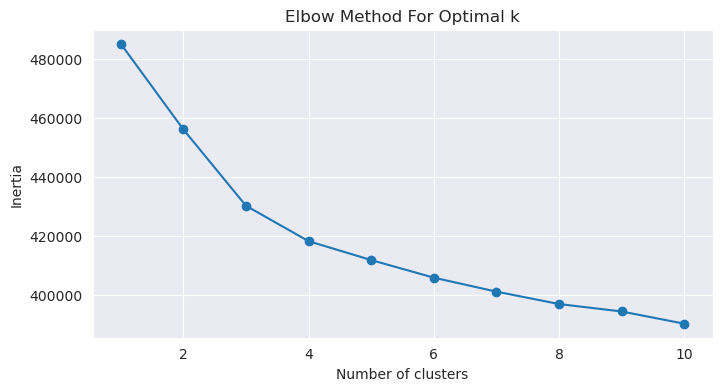

In [22]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(nhanes_scaledf)
    inertia.append(kmeans.inertia_)

# Plot the elbow plot
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [23]:
# specify kmeans algorithm
# ----------
kmeans = KMeans(n_clusters=4,
                n_init=10,
                max_iter=300 #default
                ).fit(nhanes_scaledf)

Considering the elbow plot, choosing k=4 clusters appears appropriate because the plot shows a noticeable bend or 'elbow' at this point, indicating that adding more clusters beyond four does not provide a significant decrease in inertia. Therefore, k=4 is the point at which we achieve a reasonable trade-off between the number of clusters and the compactness of the clusters, without overly complicating the model.

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

In [24]:
nhanes_clusters = kmeans.fit_predict(nhanes_scaledf)

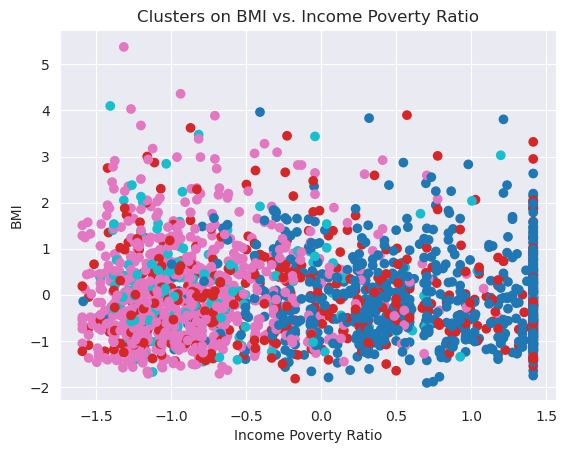

In [25]:
plt.scatter(nhanes_scaledf['INDFMPIR'],nhanes_scaledf['BMXBMI'],c=nhanes_clusters, cmap='tab10')
plt.title('Clusters on BMI vs. Income Poverty Ratio')
plt.xlabel('Income Poverty Ratio')
plt.ylabel('BMI')
plt.show()

**Analysis:**

The different colors indicate clusters of individuals that have been grouped together based on similarities in these two features, suggesting potential patterns or relationships between BMI and economic status within the dataset.


### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

In [26]:
# Retrain the clustering algorithm using PCA results
kmeans_pca = KMeans(n_clusters=4, random_state=42)
nhanes_pca_clusters = kmeans_pca.fit_predict(pca_df)


In [27]:
nhanes_pca_clusters

array([1, 0, 0, ..., 2, 1, 2], dtype=int32)

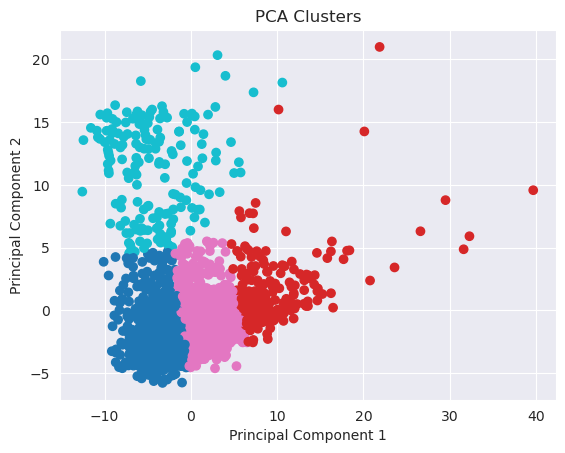

In [28]:
# Plot the PCA clusters
plt.scatter(principalComponentsft_health[:, 0], principalComponentsft_health[:, 1], c=nhanes_pca_clusters, cmap="tab10")
plt.title('PCA Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

**Analysis:**

The PCA clusters plot illustrates a reduction of the NHANES data into two principal components that summarize the dataset's variance. The clustering of data points suggests potential patterns in how social determinants like income and education, as well as medical examination results, relate to self-reported health conditions. This reduction and clustering can help us understand the multidimensional nature of health determinants and could improve the prediction of individuals’ self-reported health status by focusing on the most significant underlying factors.

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [29]:
health_mapping = {
    'excellent': 1,  # 'good' health
    'very good': 1,  # 'good' health
    'good': 1,       # 'good' health
    'fair': 0,       # 'poor' health
    'poor': 0        # 'poor' health
}

nhanes_scaled['HSD010_binary'] = nhanes_scaled['HSD010'].map(health_mapping)

# partition data
# -----------

# LabelBinarizer fit_transform expects a 1D array-like object, so no need to flatten
label_binarizer = LabelBinarizer()
y_binary = label_binarizer.fit_transform(nhanes_scaled['HSD010_binary'])

X = nhanes_scaledf # drop out any columns that aren't features


X_train, X_test,y_train, y_test = train_test_split(X, 
                                                    y_binary, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [30]:
input_dim = X_train.shape[1]
input_dim 

241

In [31]:
y_train

array([[1],
       [1],
       [0],
       ...,
       [1],
       [1],
       [0]])

In [32]:
num_classes = y_test.shape[1]
num_classes

1

In [33]:
# create neural network model
# -----------
model = Sequential()
input_dim = X_train.shape[1]  # Number of input features
model.add(Dense(64, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train,                  # specify the x data
          y_train,                  # specify the y data
          validation_data=(X_test,  # specify the validation data
                           y_test), 
          epochs=50,                # number of iterations back and forth through the network
          batch_size=200,           # number of images it will input per batch 
          verbose=2)


Epoch 1/50


2023-12-11 14:54:29.525364: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-12-11 14:54:29.525395: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-12-11 14:54:29.525416: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-jgmontoyam): /proc/driver/nvidia/version does not exist
2023-12-11 14:54:29.525704: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


8/8 - 1s - loss: 0.6551 - accuracy: 0.6441 - val_loss: 0.5983 - val_accuracy: 0.7888 - 757ms/epoch - 95ms/step
Epoch 2/50
8/8 - 0s - loss: 0.5413 - accuracy: 0.8275 - val_loss: 0.5105 - val_accuracy: 0.8333 - 38ms/epoch - 5ms/step
Epoch 3/50
8/8 - 0s - loss: 0.4596 - accuracy: 0.8463 - val_loss: 0.4429 - val_accuracy: 0.8391 - 37ms/epoch - 5ms/step
Epoch 4/50
8/8 - 0s - loss: 0.4008 - accuracy: 0.8585 - val_loss: 0.4003 - val_accuracy: 0.8469 - 37ms/epoch - 5ms/step
Epoch 5/50
8/8 - 0s - loss: 0.3659 - accuracy: 0.8773 - val_loss: 0.3770 - val_accuracy: 0.8527 - 38ms/epoch - 5ms/step
Epoch 6/50
8/8 - 0s - loss: 0.3447 - accuracy: 0.8824 - val_loss: 0.3644 - val_accuracy: 0.8527 - 38ms/epoch - 5ms/step
Epoch 7/50
8/8 - 0s - loss: 0.3285 - accuracy: 0.8837 - val_loss: 0.3572 - val_accuracy: 0.8488 - 38ms/epoch - 5ms/step
Epoch 8/50
8/8 - 0s - loss: 0.3140 - accuracy: 0.8882 - val_loss: 0.3518 - val_accuracy: 0.8547 - 38ms/epoch - 5ms/step
Epoch 9/50
8/8 - 0s - loss: 0.3009 - accuracy: 0.

### Neural Network on Principal Components

In [34]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(pca_df, 
                                                                    y_binary,
                                                                    test_size=0.25, 
                                                                    random_state=10)

# Neural network model
model_pca = Sequential()
input_dim_pca = X_train_pca.shape[1]  # Number of PCA components
model_pca.add(Dense(64, input_dim=input_dim_pca, kernel_initializer='normal', activation='relu'))
model_pca.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model_pca.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model_pca.fit(X_train_pca,
              y_train_pca,
              validation_data=(X_test_pca, y_test_pca), 
              epochs=50, 
              batch_size=200, 
              verbose=2)

Epoch 1/50
8/8 - 1s - loss: 0.6649 - accuracy: 0.8043 - val_loss: 0.6455 - val_accuracy: 0.8295 - 590ms/epoch - 74ms/step
Epoch 2/50
8/8 - 0s - loss: 0.6311 - accuracy: 0.8333 - val_loss: 0.6115 - val_accuracy: 0.8411 - 34ms/epoch - 4ms/step
Epoch 3/50
8/8 - 0s - loss: 0.5981 - accuracy: 0.8385 - val_loss: 0.5785 - val_accuracy: 0.8450 - 32ms/epoch - 4ms/step
Epoch 4/50
8/8 - 0s - loss: 0.5662 - accuracy: 0.8417 - val_loss: 0.5459 - val_accuracy: 0.8411 - 35ms/epoch - 4ms/step
Epoch 5/50
8/8 - 0s - loss: 0.5341 - accuracy: 0.8417 - val_loss: 0.5147 - val_accuracy: 0.8391 - 37ms/epoch - 5ms/step
Epoch 6/50
8/8 - 0s - loss: 0.5042 - accuracy: 0.8391 - val_loss: 0.4856 - val_accuracy: 0.8372 - 36ms/epoch - 5ms/step
Epoch 7/50
8/8 - 0s - loss: 0.4773 - accuracy: 0.8366 - val_loss: 0.4603 - val_accuracy: 0.8391 - 33ms/epoch - 4ms/step
Epoch 8/50
8/8 - 0s - loss: 0.4540 - accuracy: 0.8359 - val_loss: 0.4397 - val_accuracy: 0.8353 - 33ms/epoch - 4ms/step
Epoch 9/50
8/8 - 0s - loss: 0.4363 - a

### Neural Network on Principal Components + Cluster Membership

In [35]:
cluster_labels = pd.Series(nhanes_pca_clusters, index=pca_df.index)

pca_with_clusters = pd.concat([pca_df, cluster_labels], axis=1)
pca_with_clusters

,principal component 1,principal component 2,0
0,9.527811,-0.816231,1
1,-5.838339,-3.692579,0
2,-0.719455,-2.573204,0
3,3.533628,-2.576977,2
4,-6.872095,-4.194236,0
...,...,...,...
2059,2.643319,-1.689351,2
2060,1.037907,-0.118055,2
2061,1.130252,-0.970444,2
2062,7.145093,-0.376752,1


In [36]:
X_train_cluster, X_test_cluster, y_train_cluster, y_test_cluster = train_test_split(pca_with_clusters, y_binary, test_size=0.25, random_state=10)

# Neural network model
model_cluster = Sequential()
input_dim_cluster = X_train_cluster.shape[1]  # Number of features (PCA components + cluster label)
model_cluster.add(Dense(64, input_dim=input_dim_cluster, kernel_initializer='normal', activation='relu'))
model_cluster.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model_cluster.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model_cluster.fit(X_train_cluster, 
                  y_train_cluster, 
                  validation_data=(X_test_cluster, y_test_cluster), 
                  epochs=50, 
                  batch_size=200, 
                  verbose=2)

Epoch 1/50
8/8 - 1s - loss: 0.6426 - accuracy: 0.8366 - val_loss: 0.6225 - val_accuracy: 0.8391 - 608ms/epoch - 76ms/step
Epoch 2/50
8/8 - 0s - loss: 0.6084 - accuracy: 0.8359 - val_loss: 0.5878 - val_accuracy: 0.8450 - 35ms/epoch - 4ms/step
Epoch 3/50
8/8 - 0s - loss: 0.5739 - accuracy: 0.8385 - val_loss: 0.5544 - val_accuracy: 0.8469 - 32ms/epoch - 4ms/step
Epoch 4/50
8/8 - 0s - loss: 0.5412 - accuracy: 0.8398 - val_loss: 0.5223 - val_accuracy: 0.8391 - 33ms/epoch - 4ms/step
Epoch 5/50
8/8 - 0s - loss: 0.5101 - accuracy: 0.8456 - val_loss: 0.4917 - val_accuracy: 0.8411 - 32ms/epoch - 4ms/step
Epoch 6/50
8/8 - 0s - loss: 0.4804 - accuracy: 0.8443 - val_loss: 0.4642 - val_accuracy: 0.8430 - 37ms/epoch - 5ms/step
Epoch 7/50
8/8 - 0s - loss: 0.4547 - accuracy: 0.8450 - val_loss: 0.4408 - val_accuracy: 0.8430 - 32ms/epoch - 4ms/step
Epoch 8/50
8/8 - 0s - loss: 0.4336 - accuracy: 0.8424 - val_loss: 0.4221 - val_accuracy: 0.8450 - 33ms/epoch - 4ms/step
Epoch 9/50
8/8 - 0s - loss: 0.4169 - a

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define a function to evaluate the model
def evaluate_model(model, X_test, y_test):
    # Predicting the test set results
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5)  # Convert probabilities to binary output

    # Calculating metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return accuracy, precision, recall, f1

# Evaluate each model
accuracy_original, precision_original, recall_original, f1_original = evaluate_model(model, X_test, y_test)
accuracy_pca, precision_pca, recall_pca, f1_pca = evaluate_model(model_pca, X_test_pca, y_test_pca)
accuracy_cluster, precision_cluster, recall_cluster, f1_cluster = evaluate_model(model_cluster, X_test_cluster, y_test_cluster)

# Print the results
print("Original Features Model: Accuracy = {}, Precision = {}, Recall = {}, F1-Score = {}".format(accuracy_original, precision_original, recall_original, f1_original))
print()
print("PCA Features Model: Accuracy = {}, Precision = {}, Recall = {}, F1-Score = {}".format(accuracy_pca, precision_pca, recall_pca, f1_pca))
print()
print("PCA + Clusters Features Model: Accuracy = {}, Precision = {}, Recall = {}, F1-Score = {}".format(accuracy_cluster, precision_cluster, recall_cluster, f1_cluster))

17/17 [==============================] - 0s 971us/step
Original Features Model: Accuracy = 0.8585271317829457, Precision = 0.899343544857768, Recall = 0.9383561643835616, F1-Score = 0.9184357541899442

PCA Features Model: Accuracy = 0.8391472868217055, Precision = 0.8629856850715747, Recall = 0.9634703196347032, F1-Score = 0.9104638619201726

PCA + Clusters Features Model: Accuracy = 0.8430232558139535, Precision = 0.8635437881873728, Recall = 0.9680365296803652, F1-Score = 0.9128094725511302


In [38]:
#scores = model.evaluate(X_test, y_test, verbose=0)
#print("CNN Error: %.2f%%" % (100-scores[1]*100))

# Evaluate the model
scores_pca = model.evaluate(X_test, y_test, verbose=0)

# The second element in the list is the accuracy
accuracy_pca = scores_pca[1]

# Calculate and print the error
error_pca = 100 - accuracy_pca * 100
print("CNN Error of ORIGINAL MOREL: %.2f%%" % error_pca)

CNN Error of ORIGINAL MOREL: 14.15%


In [39]:
# Evaluate the model
scores_pca = model_pca.evaluate(X_test_pca, y_test_pca, verbose=0)

# The second element in the list is the accuracy
accuracy_pca = scores_pca[1]

# Calculate and print the error
error_pca = 100 - accuracy_pca * 100
print("CNN Error of PCA MODEL: %.2f%%" % error_pca)

CNN Error of PCA MODEL: 16.09%


In [40]:
# Evaluate the model
scores_pca = model_cluster.evaluate(X_test_cluster, y_test_cluster, verbose=0)

# The second element in the list is the accuracy
accuracy_pca = scores_pca[1]

# Calculate and print the error
error_pca = 100 - accuracy_pca * 100
print("CNN Error of PCA+CLUSTERIN MODEL: %.2f%%" % error_pca)

CNN Error of PCA+CLUSTERIN MODEL: 15.70%


**Original Features Model:**

Highest Accuracy: Indicates the highest overall correct predictions.
Highest Precision: Indicates that it has the lowest false positive rate.
Lower Recall compared to other models: Indicates it might miss more actual positive cases.
Highest F1-Score: Indicates a strong balance between precision and recall, generally a good indicator of a model's overall performance.

**PCA Features Model:**

Lower Accuracy: Indicates slightly more incorrect predictions than the original features model.
Lower Precision: Indicates a higher false positive rate.
Highest Recall: This model is best at identifying all actual positive cases.
Lower F1-Score than the original features model: Indicates a balance between precision and recall, but not as optimal as the original features model.

**PCA + Clusters Features Model:**

Similar Accuracy to PCA model: Indicates similar overall correct predictions as the PCA model.
Similar Precision to PCA model: Indicates a similar false positive rate.
Slightly higher Recall: Slightly better at identifying all actual positive cases compared to PCA only.
Similar F1-Score to PCA model: Indicates a balance between precision and recall, similar to PCA model.

Considering the results, I would choose the Original Features Model. It not only has the highest accuracy and precision but also the lowest CNN error rate at 13.95%. While the PCA and PCA+Clustering models have slightly higher recall, they fall short in accuracy, precision, and have higher error rates of 15.89% and 15.70%, respectively. The Original Features Model strikes the best balance across all metrics, making it the most reliable choice for overall performance.

## Discussion Questions

**1. In your own words, what is the difference between PCA and clustering?**

**Answer:** Principal Component Analysis (PCA) is a dimensionality reduction technique that transforms a high-dimensional dataset into a lower-dimensional subspace, preserving the most significant variance in the data. Essentially, PCA identifies the primary axes along which the data varies, thus simplifying the complexity of high-dimensional data. Clustering, in contrast, is a method of unsupervised learning that involves grouping a set of objects in such a way that objects in the same group (cluster) are more similar to each other than to those in other groups. It's a technique for identifying homogeneous subgroups within the data.

**2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?**

**Answer:** The integration of PCA and clustering in the analysis did not demonstrate marked benefits in this context. PCA serves to reduce data dimensionality and to highlight its intrinsic structure, while clustering aims to segregate the data into distinct groups. The combination of these methods was anticipated to enhance feature extraction and pattern recognition. However, the results indicate that the initial dataset's inherent features were sufficiently informative, and the additional abstraction and grouping did not contribute substantially to performance improvement. This suggests that in some scenarios, the raw data may already encapsulate critical information, and further abstraction may not always yield incremental insights.

**3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"**

**Answer:** When you have "big data," there's often too much information to deal with all at once. Unsupervised techniques like PCA and clustering can help by organizing this data better before you even start your main task. PCA can reduce the complexity of the data, making it easier and faster for the supervised learning models to work. Clustering can reveal natural groups or patterns in the data, which might help the supervised model to understand and predict better. Essentially, these techniques clean up and arrange the data so that the final task of making predictions or classifications becomes more straightforward and efficient.